# 2-5. Pose Estimation, Action Recognition

In [1]:
!pip3 install --upgrade mxnet-cu101 > /dev/null
!pip3 install --upgrade gluoncv > /dev/null

tcmalloc: large alloc 1147494400 bytes == 0x65390000 @  0x7f7271077615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
ERROR: distributed 2021.1.0 has requirement dask>=2020.12.0, but you'll have dask 2.12.0 which is incompatible.
ERROR: botocore 1.19.56 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


## Pose Estimation

### Pose Estimation Framework
<img src='https://res.infoq.com/articles/human-pose-estimation-ai-powered-fitness-apps/en/resources/30image001-1602703271382.jpg' width=100% />

- heatmap

<img src='https://res.infoq.com/articles/human-pose-estimation-ai-powered-fitness-apps/en/resources/25image003-1602703274021.jpg' />

### Simple Pose Estimation
- input size : 256*192

In [2]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

In [3]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

88993KB [00:03, 26500.33KB/s]                           


55763KB [00:02, 23272.88KB/s]                           


In [4]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

1562KB [00:00, 23138.09KB/s]            

Shape of pre-processed image: (1, 3, 512, 605)


In [5]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

In [6]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

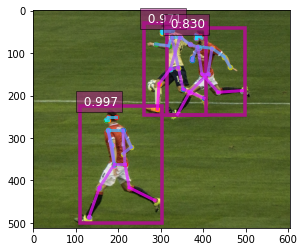

In [7]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.rcParams["figure.figsize"] = (20,15)
plt.show()

### AlphaPose Estimation
- input size : 320*256

In [8]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_alpha_pose, heatmap_to_coord_alpha_pose

In [9]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('alpha_pose_resnet101_v1b_coco', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

216179KB [00:06, 35217.94KB/s]                            


In [10]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.yolo.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

Shape of pre-processed image: (1, 3, 512, 605)


In [11]:
pose_input, upscale_bbox = detector_to_alpha_pose(img, class_IDs, scores, bounding_boxs)


In [12]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord_alpha_pose(predicted_heatmap, upscale_bbox)

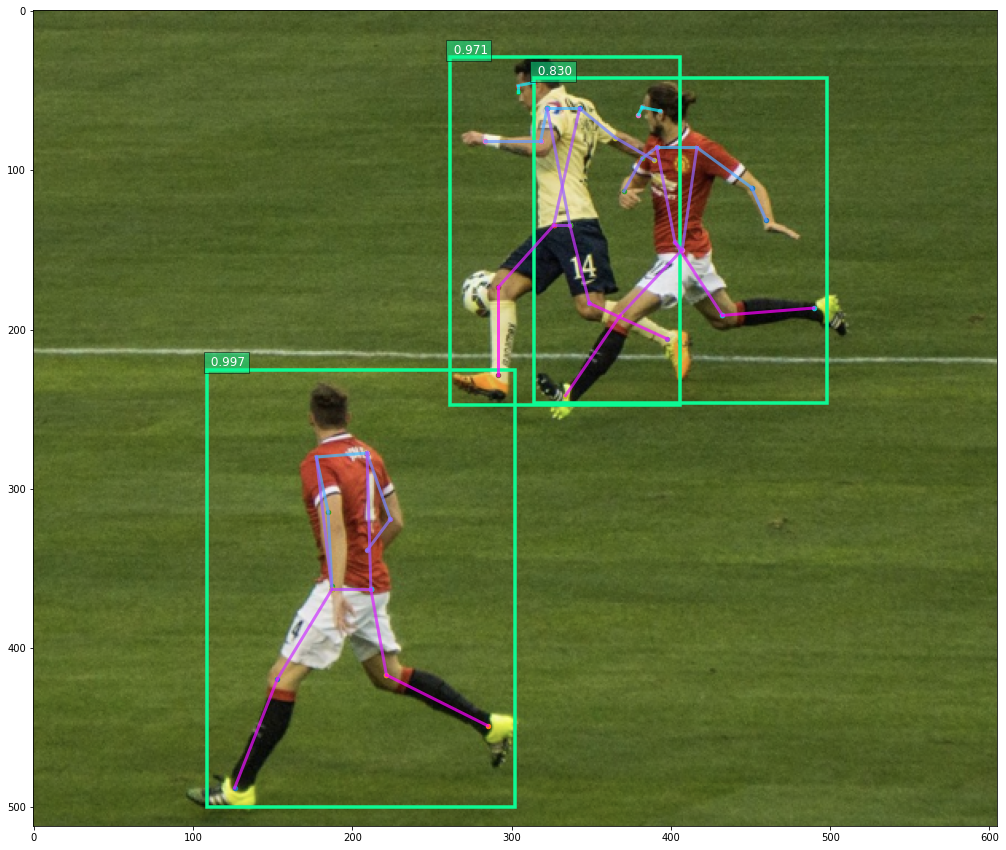

In [13]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

## Action Recognition

### TSN (UCF101)
- Temporal Segment Networks

#### TSN Framework
<img src='https://blog.kakaocdn.net/dn/cPmbiR/btqI4UwbnXz/c6UOHFYP5ia2hdWbKH5lhk/img.png' width=100% />

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

148KB [00:00, 4951.36KB/s]             


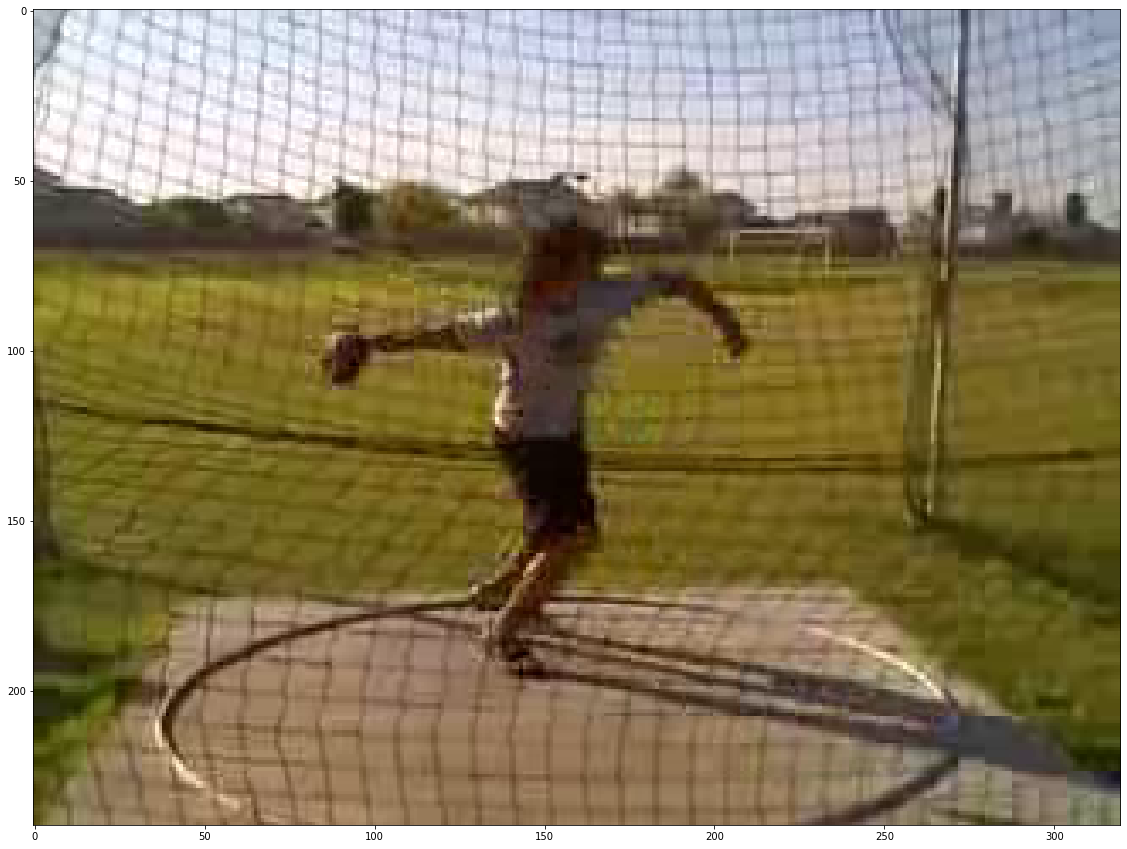

In [15]:
url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/ThrowDiscus.png'
im_fname = utils.download(url)

img = image.imread(im_fname)

plt.imshow(img.asnumpy())
plt.show()

In [16]:
transform_fn = transforms.Compose([
    video.VideoCenterCrop(size=224),
    video.VideoToTensor(),
    video.VideoNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

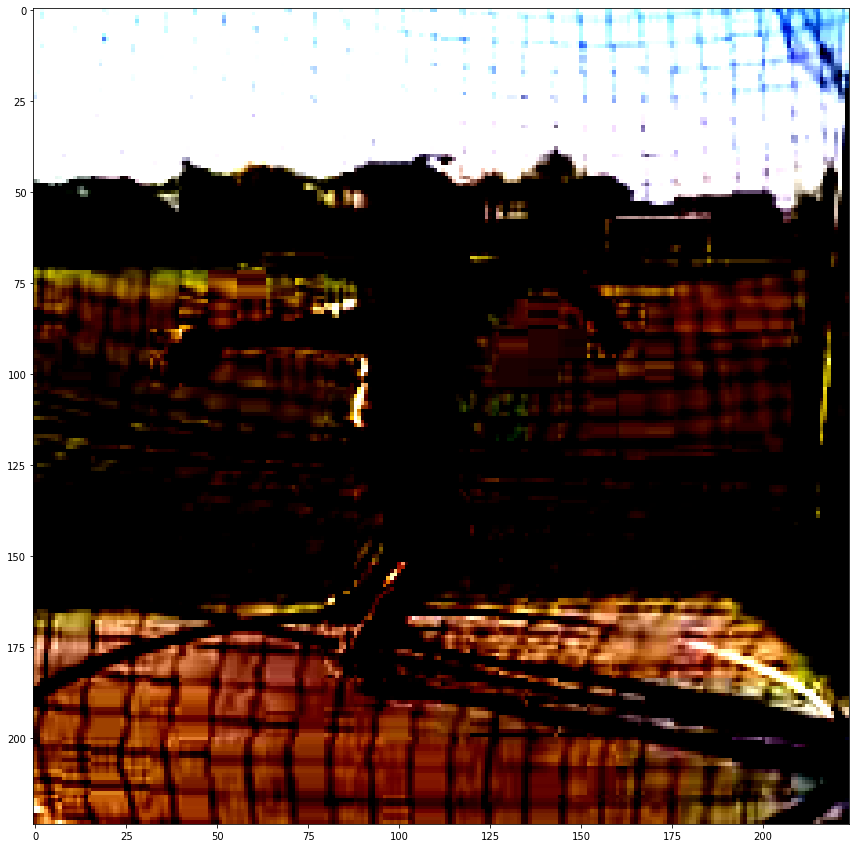

In [17]:
img_list = transform_fn([img.asnumpy()])
plt.imshow(np.transpose(img_list[0], (1,2,0)))
plt.show()

In [18]:
net = get_model('vgg16_ucf101', nclass=101, pretrained=True)

100%|██████████| 500159/500159 [00:14<00:00, 34181.89KB/s]


486864KB [00:14, 32746.44KB/s]                            


#### TSN Layer

In [19]:
net.summary

<bound method Block.summary of ActionRecVGG16(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_siz

In [20]:
pred = net(nd.array(img_list[0]).expand_dims(axis=0))

classes = net.classes
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video frame is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video frame is classified to be
	[ThrowDiscus], with probability 0.998.
	[HorseRace], with probability 0.001.
	[VolleyballSpiking], with probability 0.001.
	[Hammering], with probability 0.000.
	[TennisSwing], with probability 0.000.


In [21]:
from gluoncv.utils import try_import_cv2
cv2 = try_import_cv2()

url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/v_Basketball_g01_c01.avi'
video_fname = utils.download(url)

cap = cv2.VideoCapture(video_fname)
cnt = 0
video_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    cnt += 1
    if ret and cnt % 25 == 0:
        video_frames.append(frame)
    if not ret: break

cap.release()
print('We evenly extract %d frames from the video %s.' % (len(video_frames), video_fname))

282KB [00:00, 7694.32KB/s]             


We evenly extract 5 frames from the video v_Basketball_g01_c01.avi.


In [22]:
if video_frames:
    video_frames_transformed = transform_fn(video_frames)
    final_pred = 0
    for _, frame_img in enumerate(video_frames_transformed):
        pred = net(nd.array(frame_img).expand_dims(axis=0))
        final_pred += pred
    final_pred /= len(video_frames)

    classes = net.classes
    topK = 5
    ind = nd.topk(final_pred, k=topK)[0].astype('int')
    print('The input video is classified to be')
    for i in range(topK):
        print('\t[%s], with probability %.3f.'%
              (classes[ind[i].asscalar()], nd.softmax(final_pred)[0][ind[i]].asscalar()))

The input video is classified to be
	[Basketball], with probability 0.978.
	[TennisSwing], with probability 0.020.
	[SoccerJuggling], with probability 0.002.
	[VolleyballSpiking], with probability 0.000.
	[JavelinThrow], with probability 0.000.


### I3D (Kinetcis400)

#### I3D Framework
- Inflated 3D ConvNet
<img src='https://www.researchgate.net/profile/Jamil_Ahmad13/publication/321352236/figure/fig6/AS:668725271351305@1536447937705/Framework-of-the-proposed-DB-LSTM-for-action-recognition-action-recognition-The-output.png' width=100% />

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

In [24]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/abseiling_k400.mp4'
video_fname = utils.download(url)
vr = decord.VideoReader(video_fname)
frame_id_list = range(0, 64, 2)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

100%|██████████| 782/782 [00:00<00:00, 13675.33KB/s]


In [25]:
transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (32, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is downloaded and preprocessed.')

Video data is downloaded and preprocessed.


In [26]:
model_name = 'i3d_inceptionv1_kinetics400'
net = get_model(model_name, nclass=400, pretrained=True)
print('%s model is successfully loaded.' % model_name)

51278KB [00:02, 23540.99KB/s]                           


i3d_inceptionv1_kinetics400 model is successfully loaded.


#### I3D layer

In [27]:
net.summary

<bound method Block.summary of I3D_InceptionV1(
  (features): HybridSequential(
    (0): HybridSequential(
      (0): Conv3D(3 -> 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (2): Activation(relu)
    )
    (1): MaxPool3D(size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
    (2): HybridSequential(
      (0): Conv3D(64 -> 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (2): Activation(relu)
    )
    (3): HybridSequential(
      (0): Conv3D(64 -> 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm(axis=1, eps=0.001, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=192)
      (2): Activati

In [28]:
pred = net(nd.array(clip_input))

classes = net.classes
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
	[abseiling], with probability 0.991.
	[rock_climbing], with probability 0.009.
	[ice_climbing], with probability 0.000.
	[paragliding], with probability 0.000.
	[skydiving], with probability 0.000.


### SlowFast (Kinetcis400)

#### SlowFast Framework
<img src='https://miro.medium.com/max/700/0*WLTSCRGi1DNfqyyi.png' width=100% />

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.data.transforms import video
from gluoncv import utils
from gluoncv.model_zoo import get_model

In [30]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

url = 'https://github.com/bryanyzhu/tiny-ucf101/raw/master/abseiling_k400.mp4'
video_fname = utils.download(url)
vr = decord.VideoReader(video_fname)
fast_frame_id_list = range(0, 64, 2)
slow_frame_id_list = range(0, 64, 16)
frame_id_list = list(fast_frame_id_list) + list(slow_frame_id_list)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

In [31]:
transform_fn = video.VideoGroupValTransform(size=224, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (36, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is downloaded and preprocessed.')

Video data is downloaded and preprocessed.


In [32]:
model_name = 'slowfast_4x16_resnet50_kinetics400'
net = get_model(model_name, nclass=400, pretrained=True)
print('%s model is successfully loaded.' % model_name)

100%|██████████| 134964/134964 [00:04<00:00, 28228.42KB/s]


slowfast_4x16_resnet50_kinetics400 model is successfully loaded.


#### slowfast Layer

In [33]:
net.summary

<bound method Block.summary of SlowFast(
  (fast_conv1): Conv3D(3 -> 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
  (fast_bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
  (fast_relu): Activation(relu)
  (fast_maxpool): MaxPool3D(size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (fast_res2): HybridSequential(
    (0): Bottleneck(
      (conv1): Conv3D(8 -> 8, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv2): Conv3D(8 -> 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=8)
      (conv3): Conv3D(8 -> 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)

In [34]:
pred = net(nd.array(clip_input))

classes = net.classes
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
	[abseiling], with probability 0.996.
	[rock_climbing], with probability 0.004.
	[ice_climbing], with probability 0.000.
	[paragliding], with probability 0.000.
	[climbing_a_rope], with probability 0.000.


## Object Tracking

### SiamRPN

In [35]:
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import mxnet as mx
from gluoncv import model_zoo, utils
from gluoncv.model_zoo.siamrpn.siamrpn_tracker import SiamRPNTracker as build_tracker
from gluoncv.model_zoo.siamrpn.siamrpn_tracker import get_axis_aligned_bbox
from gluoncv.utils.filesystem import try_import_cv2
cv2 = try_import_cv2()

In [36]:
from gluoncv import utils
video_path = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/tracking/Coke.mp4'
im_video = utils.download(video_path)
gt_bbox = [298, 160, 48, 80]

 16%|█▌        | 1548/9652 [00:00<00:00, 15478.94KB/s]

9653KB [00:00, 29525.16KB/s]                          


In [37]:
def read_data(video_path): 
    video_frames = [] 
    im_video = utils.download(video_path)
    cap = cv2.VideoCapture(im_video)
    while(True):
        ret, img = cap.read()
        if not ret:
            break
        video_frames.append(img)
    
    return video_frames

In [38]:
def inference(video_frames, tracker, gt_bbox, save_dir): 
    scores = []
    pred_bboxes = []
    gt_bbox = list(map(int, gt_bbox))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for ind, frame in enumerate(video_frames):
        if ind == 0:
            cx, cy, w, h = get_axis_aligned_bbox(np.array(gt_bbox))
            gt_bbox_ = [cx-(w-1)/2, cy-(h-1)/2, w, h]
            tracker.init(frame, gt_bbox_, ctx=mx.cpu())
            pred_bbox = gt_bbox_
            scores.append(None)
            pred_bboxes.append(pred_bbox)
        else:
            outputs = tracker.track(frame, ctx=mx.cpu())
            pred_bbox = outputs['bbox']
            pred_bboxes.append(pred_bbox)
            scores.append(outputs['best_score'])
        pred_bbox = list(map(int, pred_bbox))
        cv2.rectangle(frame, (pred_bbox[0], pred_bbox[1]),
                      (pred_bbox[0]+pred_bbox[2], pred_bbox[1]+pred_bbox[3]),
                      (0, 255, 255), 3)
        cv2.imwrite(os.path.join(save_dir, '%04d.jpg'%(ind+1)), frame)

In [39]:
net = model_zoo.get_model('siamrpn_alexnet_v2_otb15', ctx=mx.cpu(), pretrained=True)


100%|██████████| 24446/24446 [00:01<00:00, 15777.11KB/s]


In [40]:
tracker = build_tracker(net)


In [41]:
video_path = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/tracking/Coke.mp4'

In [42]:
video_frames = read_data(video_path)


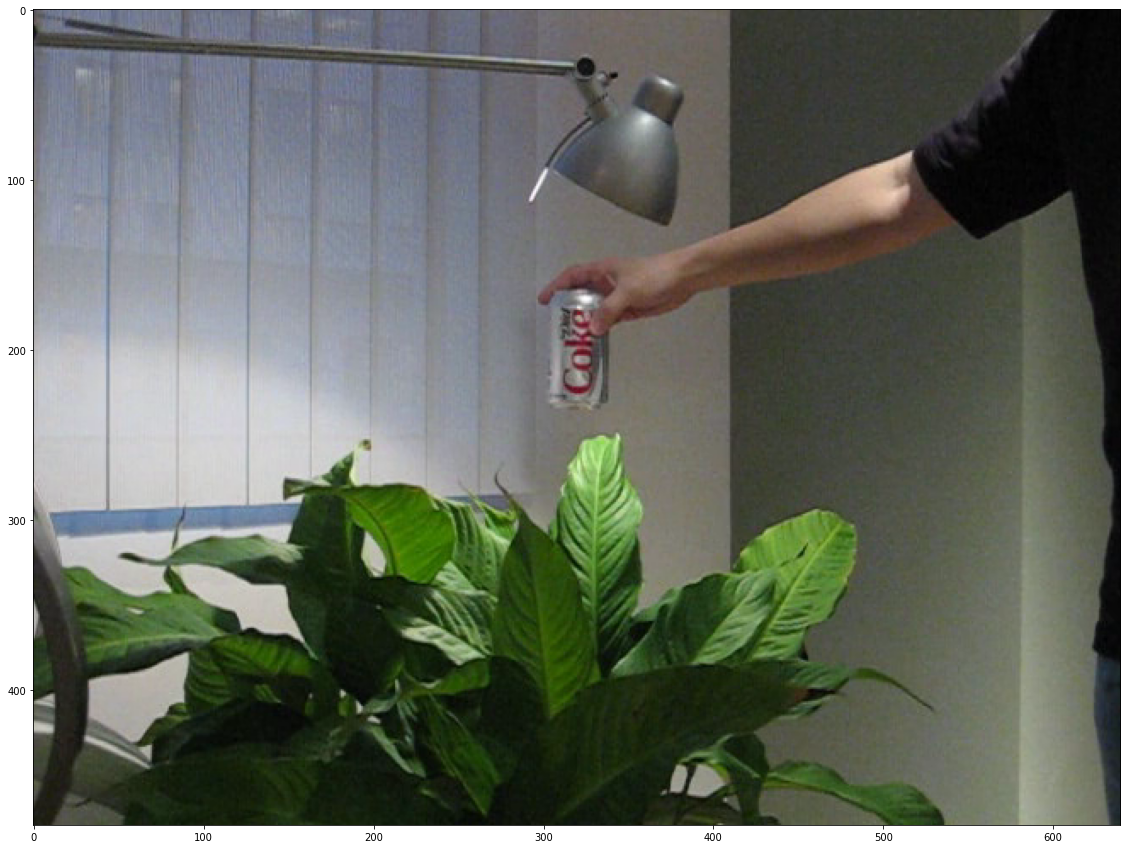

In [43]:
# BGR -> RGB
plt.imshow(video_frames[0][:,:,[2,1,0]])
plt.show()


In [44]:
gt_bbox = [298, 160, 48, 80]
save_dir = './predictions'

In [45]:
inference(video_frames, tracker, gt_bbox, save_dir) 

## 저장된 이미지 확인

In [46]:
import os

In [47]:
file_list = os.listdir(save_dir)

In [48]:
file_list.sort()

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

In [50]:
def img_file_to_gif(img_root, img_files, output_file_name): 
    imgs_array = [np.array(imageio.imread(img_root + '/' + img_file)) for img_file in img_files] 
    imageio.mimsave(output_file_name, imgs_array, format='GIF', fps=24)

In [51]:
img_file_to_gif(save_dir, file_list, "coke_tracking.gif")


- downsize

In [52]:
!apt-get install -y gifsicle

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  gifsicle
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 134 kB of archives.
After this operation, 385 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gifsicle amd64 1.91-2 [134 kB]
Fetched 134 kB in 1s (95.5 kB/s)
Selecting previously unselected package gifsicle.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../gifsicle_1.91-2_amd64.deb ...
Unpacking gifsicle (1.91-2) ...
Setting up gifsicle (1.91-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [53]:
!pip3 install pygifsicle

  Created wheel for pygifsicle: filename=pygifsicle-1.0.2-cp36-none-any.whl size=4518 sha256=eff72b9522542f0755f88b9146eb60dd5e4c6e47f4f45c7e41c4e512fb8bc6f5
  Stored in directory: /root/.cache/pip/wheels/7d/9a/33/113116a2b70d0f359bdafc3ee5270bf6f73f0d8bea06907815
Successfully built pygifsicle


In [54]:
from pygifsicle import optimize


In [56]:
optimize("./coke_tracking.gif")

![coke](./content/coke_tracking.gif)